In [1]:
%matplotlib notebook

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from IPython.display import display, display_markdown

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

sns.set(style='whitegrid', palette='Set2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# unigram
df_uni = pd.read_csv('dedup.en.words.unigrams.tsv', sep='\t')
total_unigrams = df_uni['unigram_freq'].sum()
display_md(f'Total number of unigrams: {total_unigrams}')
df_uni['unigram_freq'] = df_uni['unigram_freq'] / total_unigrams
df_uni['log_unigram_freq'] = np.log10(df_uni['unigram_freq'])
df_uni = df_uni.drop(columns='unigram_freq')
display(df_uni.head())

Total number of unigrams: 750595864

unigram  log_unigram_freq
0     the         -1.447468
1     you         -1.464249
2       i         -1.476922
3      to         -1.588910
4       a         -1.670625

In [3]:
# bigram
df_bi = pd.read_csv('dedup.en.words.bigrams.tsv', sep='\t')
df_bi = df_bi[df_bi['bigram_freq'] > 1]
total_bigrams = df_bi['bigram_freq'].sum()
display_md(f'Total number of bigrams: {total_bigrams} (we threw some low-frequency ones away)')
df_bi['bigram_freq'] = df_bi['bigram_freq'] / total_unigrams
df_bi['log_bigram_freq'] = np.log10(df_bi['bigram_freq'])
df_bi = df_bi.drop(columns='bigram_freq')
display(df_bi.head())

Total number of bigrams: 641156607 (we threw some low-frequency ones away)

bigram  log_bigram_freq
0     i m        -2.320121
1    it s        -2.342565
2   don t        -2.370733
3  you re        -2.530850
4  in the        -2.539749

In [4]:
# word1/word2
df_bi['word1'] = df_bi['bigram'].apply(lambda x: x.split(' ')[0])
df_bi['word2'] = df_bi['bigram'].apply(lambda x: x.split(' ')[1])
df_bi = df_bi.merge(df_uni.rename(columns={'unigram': 'word1', 'log_unigram_freq': 'log_word1_freq'}), how='left', on='word1')
df_bi = df_bi.merge(df_uni.rename(columns={'unigram': 'word2', 'log_unigram_freq': 'log_word2_freq'}), how='left', on='word2')
display(df_bi.head())

bigram  log_bigram_freq word1 word2  log_word1_freq  log_word2_freq
0     i m        -2.320121     i     m       -1.476922       -2.307584
1    it s        -2.342565    it     s       -1.799641       -1.771602
2   don t        -2.370733   don     t       -2.364607       -1.939389
3  you re        -2.530850   you    re       -1.464249       -2.289862
4  in the        -2.539749    in   the       -1.941774       -1.447468

In [5]:
# ftp/btp
df_bi['log_ftp'] = df_bi['log_bigram_freq'] - df_bi['log_word1_freq']
df_bi['log_btp'] = df_bi['log_bigram_freq'] - df_bi['log_word2_freq']
df_bi['pmi'] = df_bi['log_bigram_freq'] - df_bi['log_word1_freq'] - df_bi['log_word2_freq']
display(df_bi.head())

bigram  log_bigram_freq word1 word2  log_word1_freq  log_word2_freq  \
0     i m        -2.320121     i     m       -1.476922       -2.307584   
1    it s        -2.342565    it     s       -1.799641       -1.771602   
2   don t        -2.370733   don     t       -2.364607       -1.939389   
3  you re        -2.530850   you    re       -1.464249       -2.289862   
4  in the        -2.539749    in   the       -1.941774       -1.447468   

    log_ftp   log_btp       pmi  
0 -0.843199 -0.012538  1.464385  
1 -0.542925 -0.570963  1.228678  
2 -0.006126 -0.431344  1.933263  
3 -1.066602 -0.240988  1.223261  
4 -0.597975 -1.092281  0.849493

In [6]:
# store df
df_bi.to_csv('full_bigram_data.tsv', sep='\t', index=False)

In [7]:
# load df
df_bi = pd.read_csv('full_bigram_data.tsv', sep='\t')

<IPython.core.display.Javascript object>


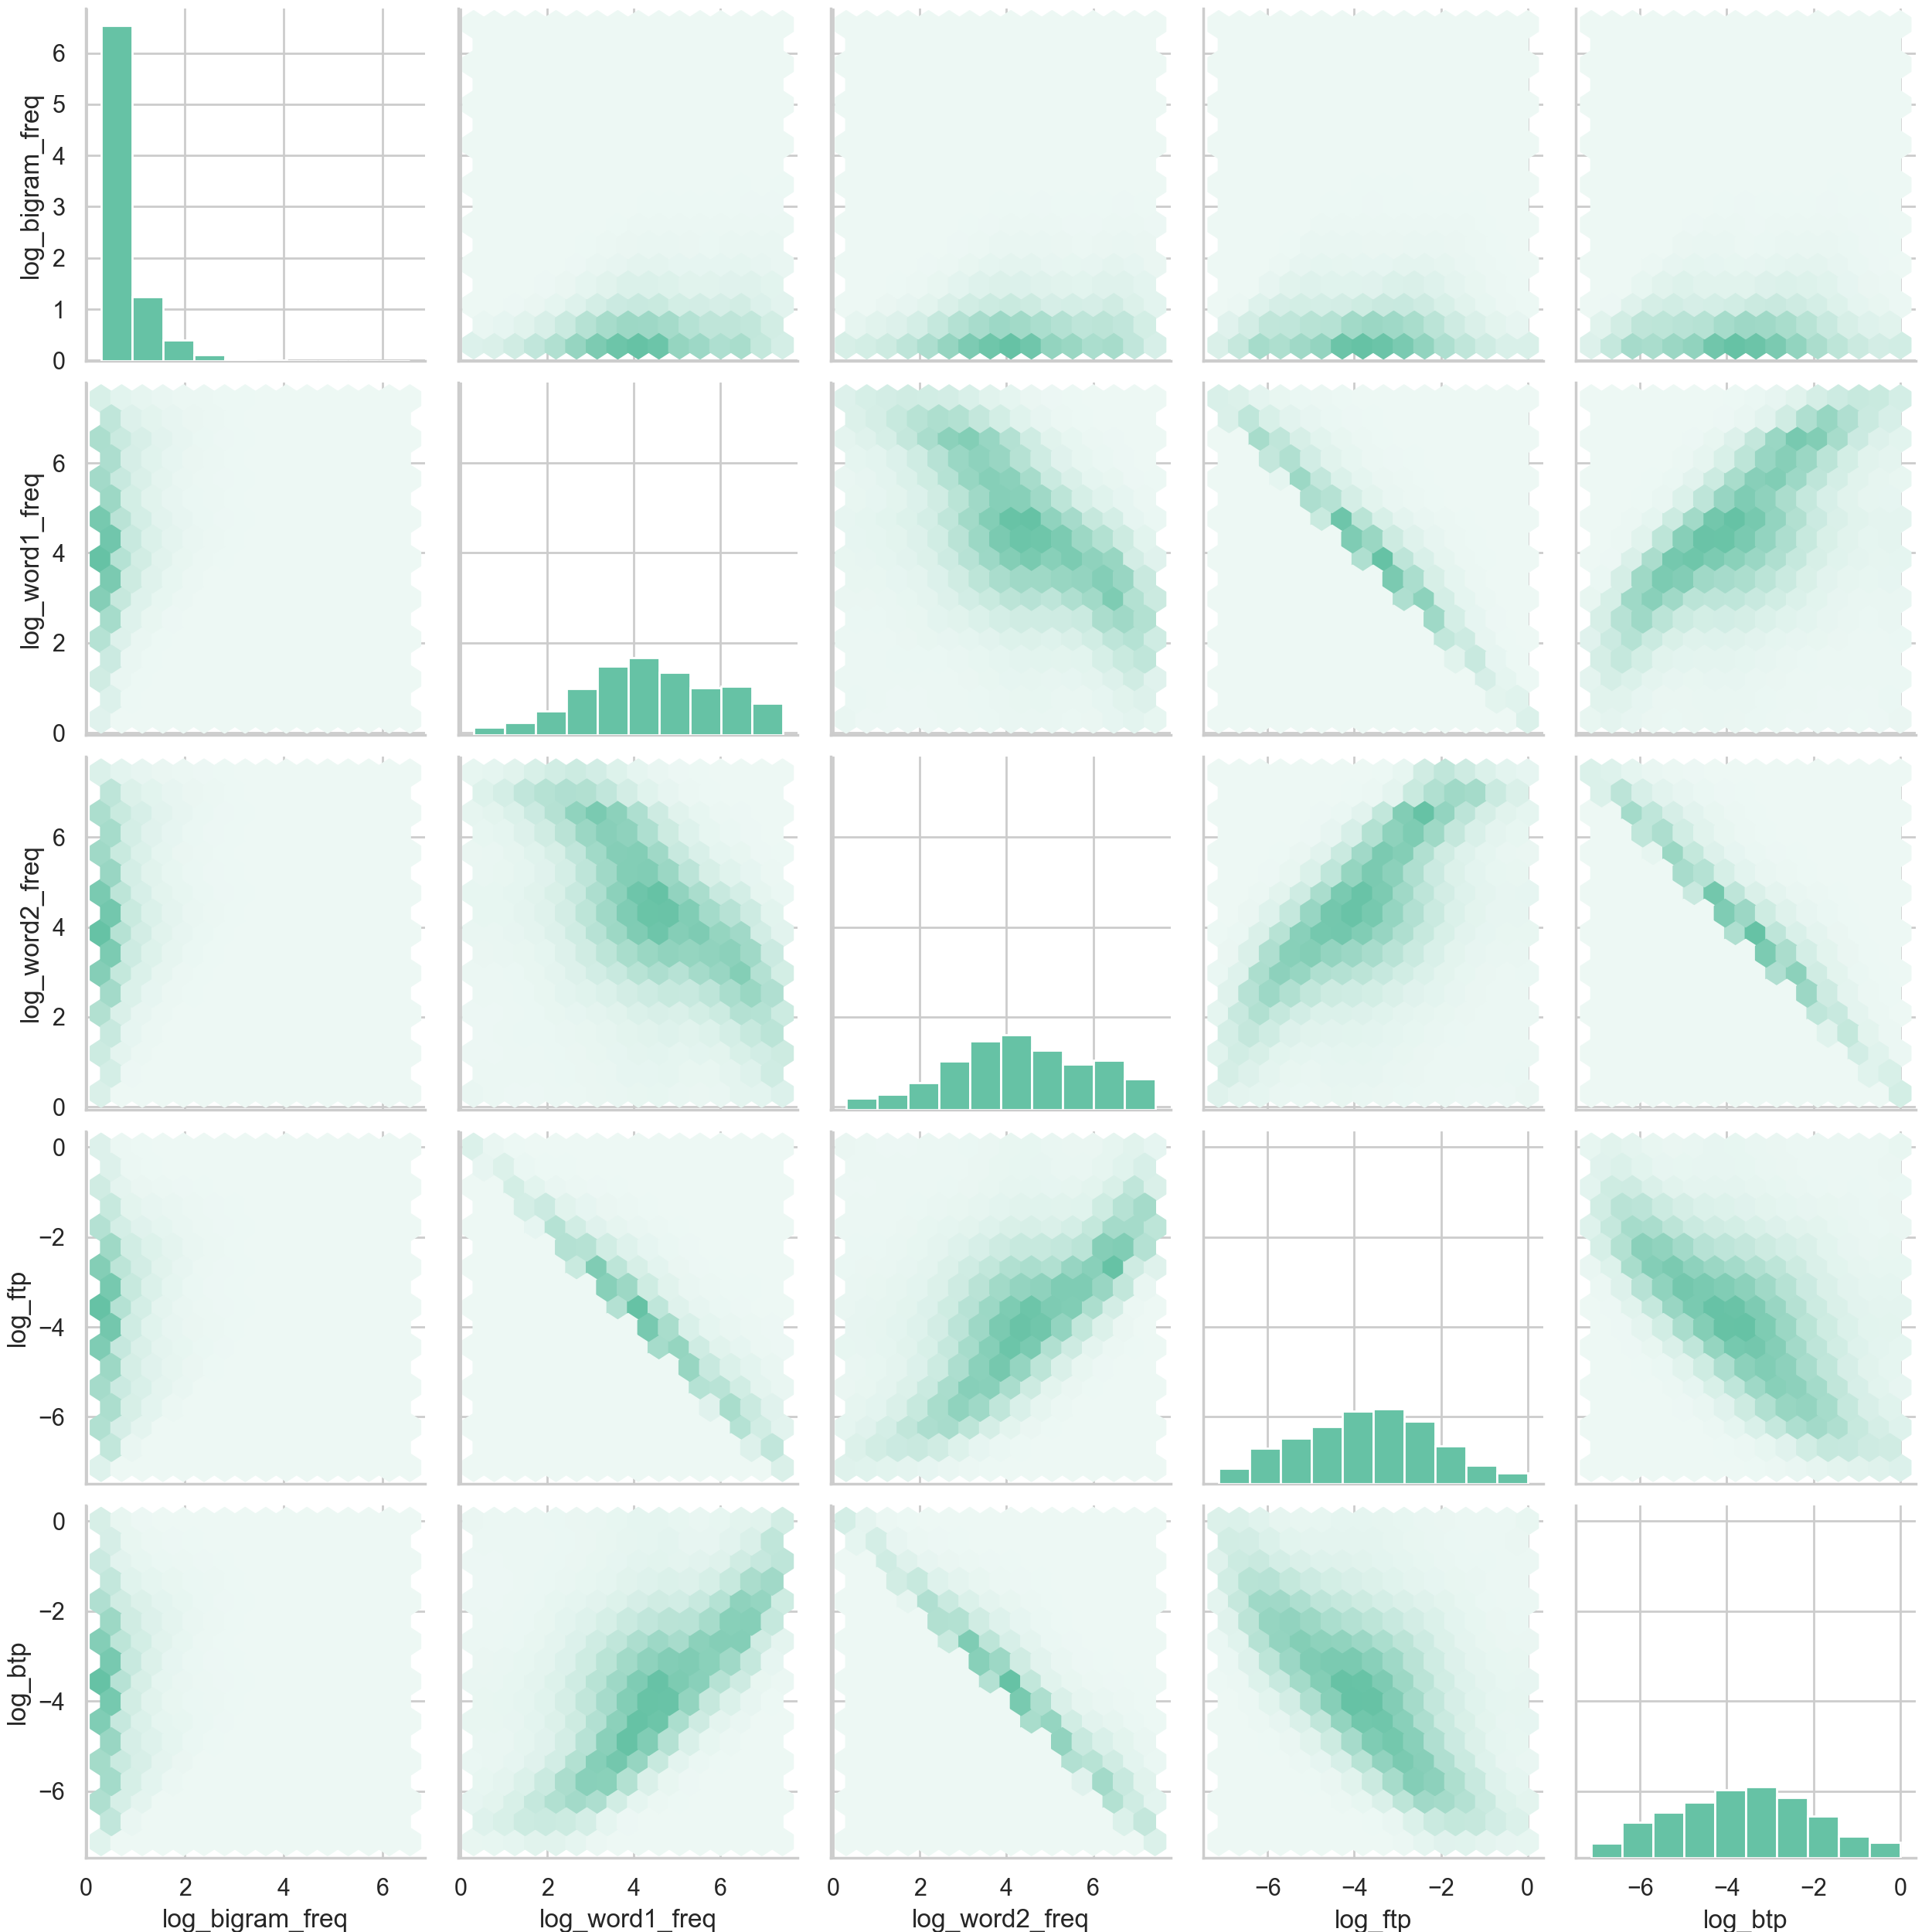

In [10]:
g = sns.PairGrid(df_bi)
g = g.map_diag(plt.hist)

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

g = g.map_offdiag(hexbin)

<IPython.core.display.Javascript object>


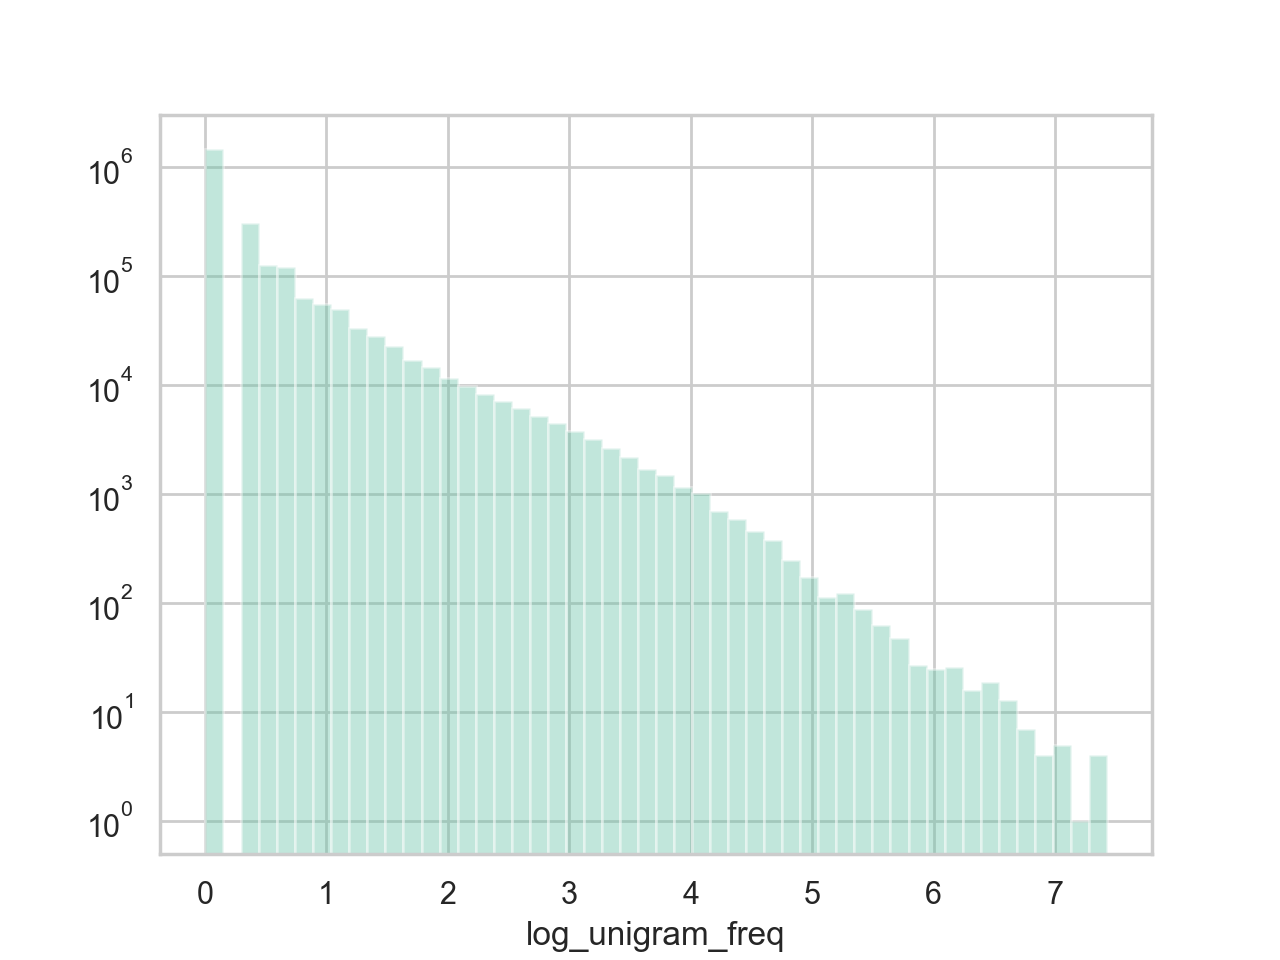

In [50]:
g = sns.distplot(df_uni['log_unigram_freq'], kde=False)
g.set(yscale='log');

<IPython.core.display.Javascript object>


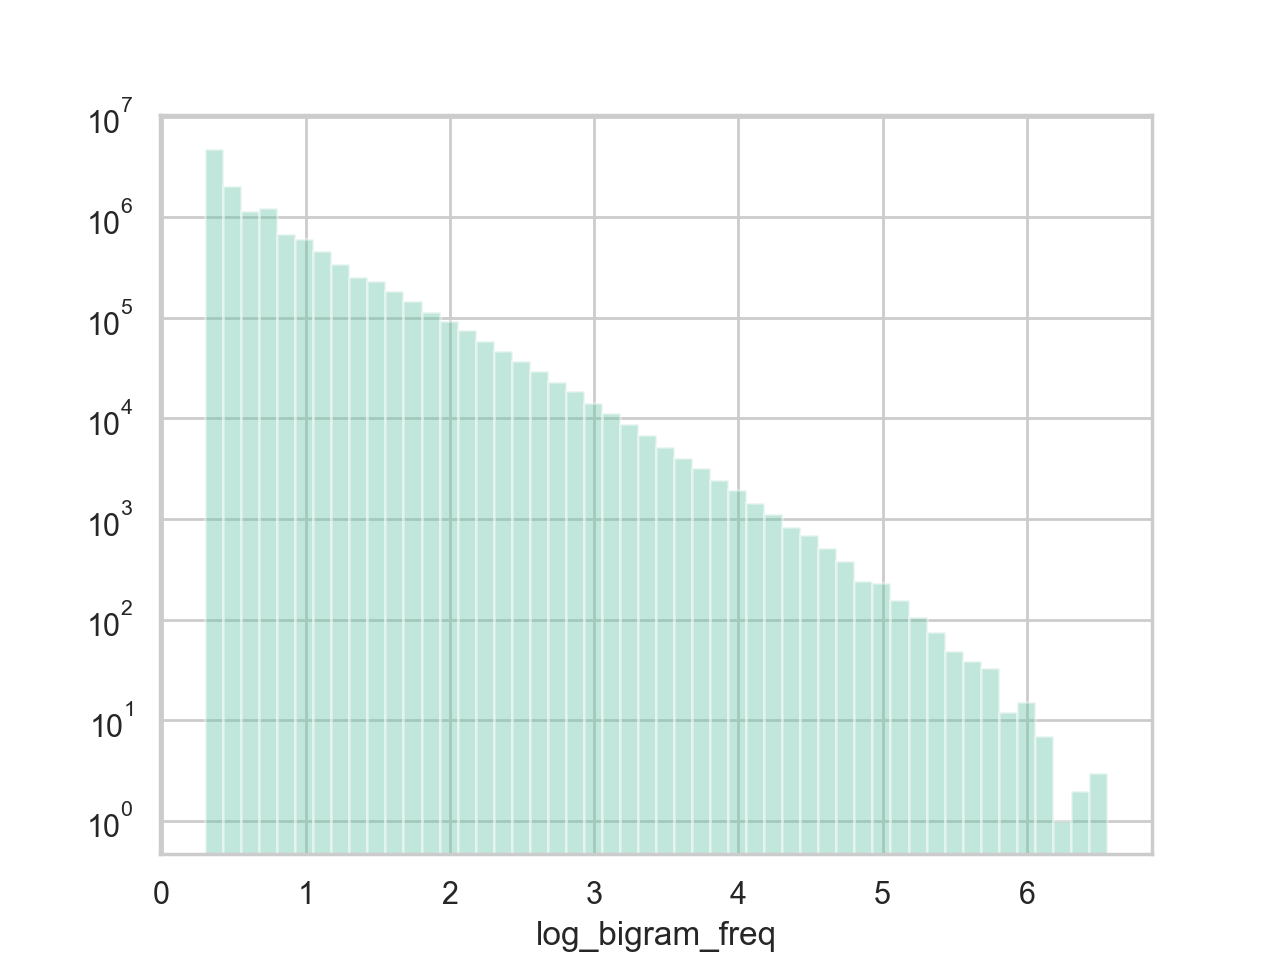

In [63]:
g = sns.distplot(df_bi['log_bigram_freq'], kde=False)
g.set(yscale='log');

<IPython.core.display.Javascript object>


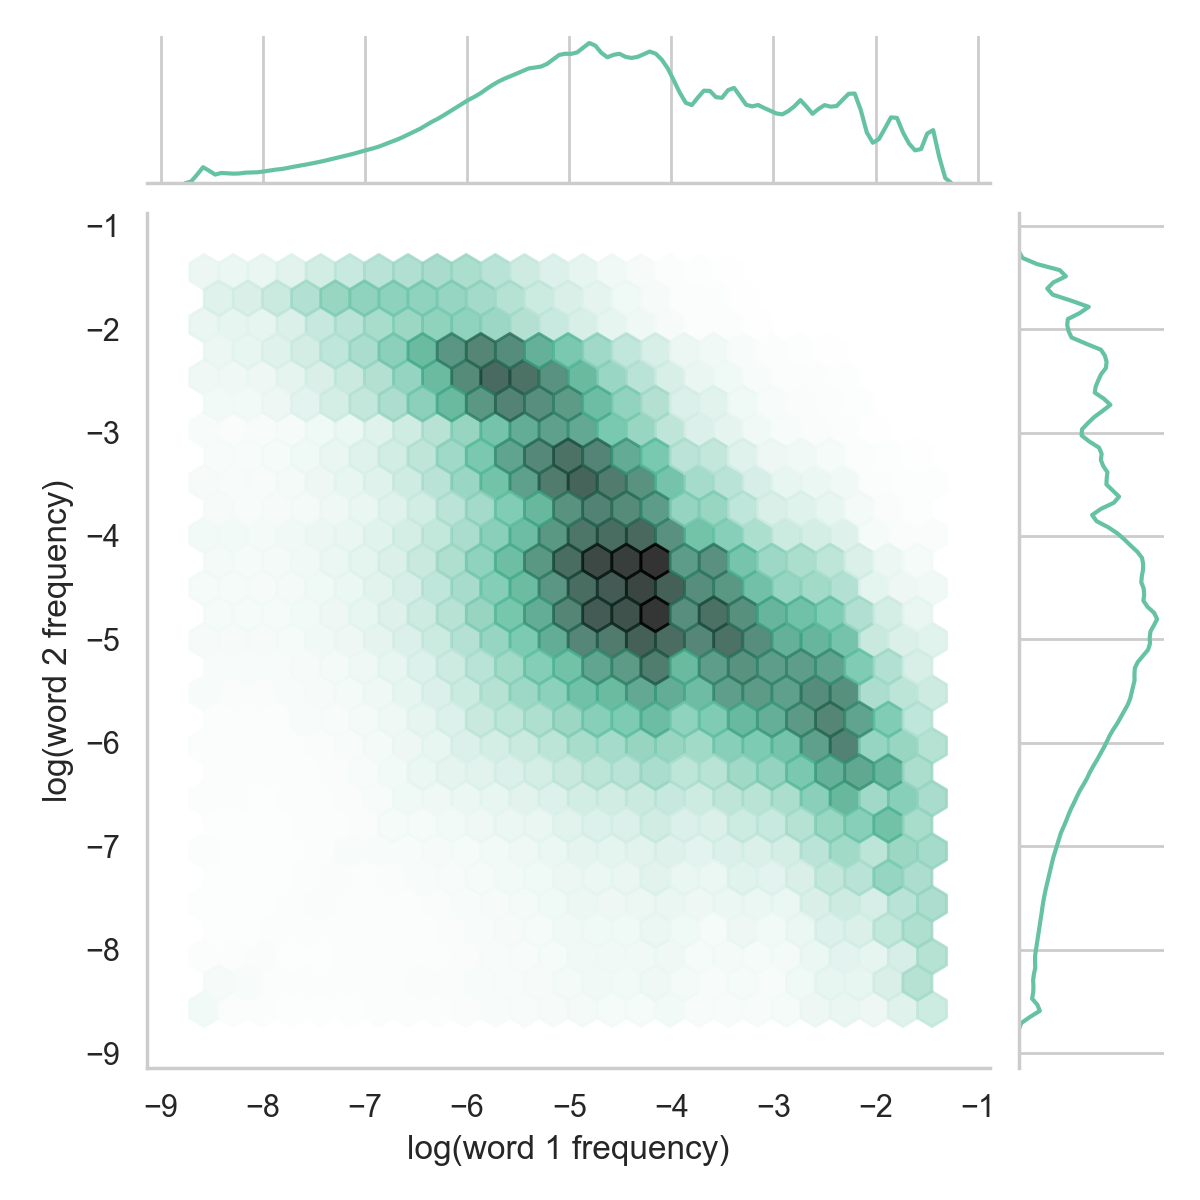

In [56]:
x = df_bi['log_word1_freq']
y = df_bi['log_word2_freq']
g = sns.jointplot(x, y,
                  kind='hex',
                  alpha=.8,
                  joint_kws={'gridsize': 25},
                  marginal_kws={'hist': False, 'kde': True},
                 )
g.ax_joint.set(xlabel='log(word 1 frequency)', ylabel='log(word 2 frequency)')
g.ax_joint.grid(False)

#sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

plt.savefig('figures/word1_word2_hexplot.pdf')

<IPython.core.display.Javascript object>


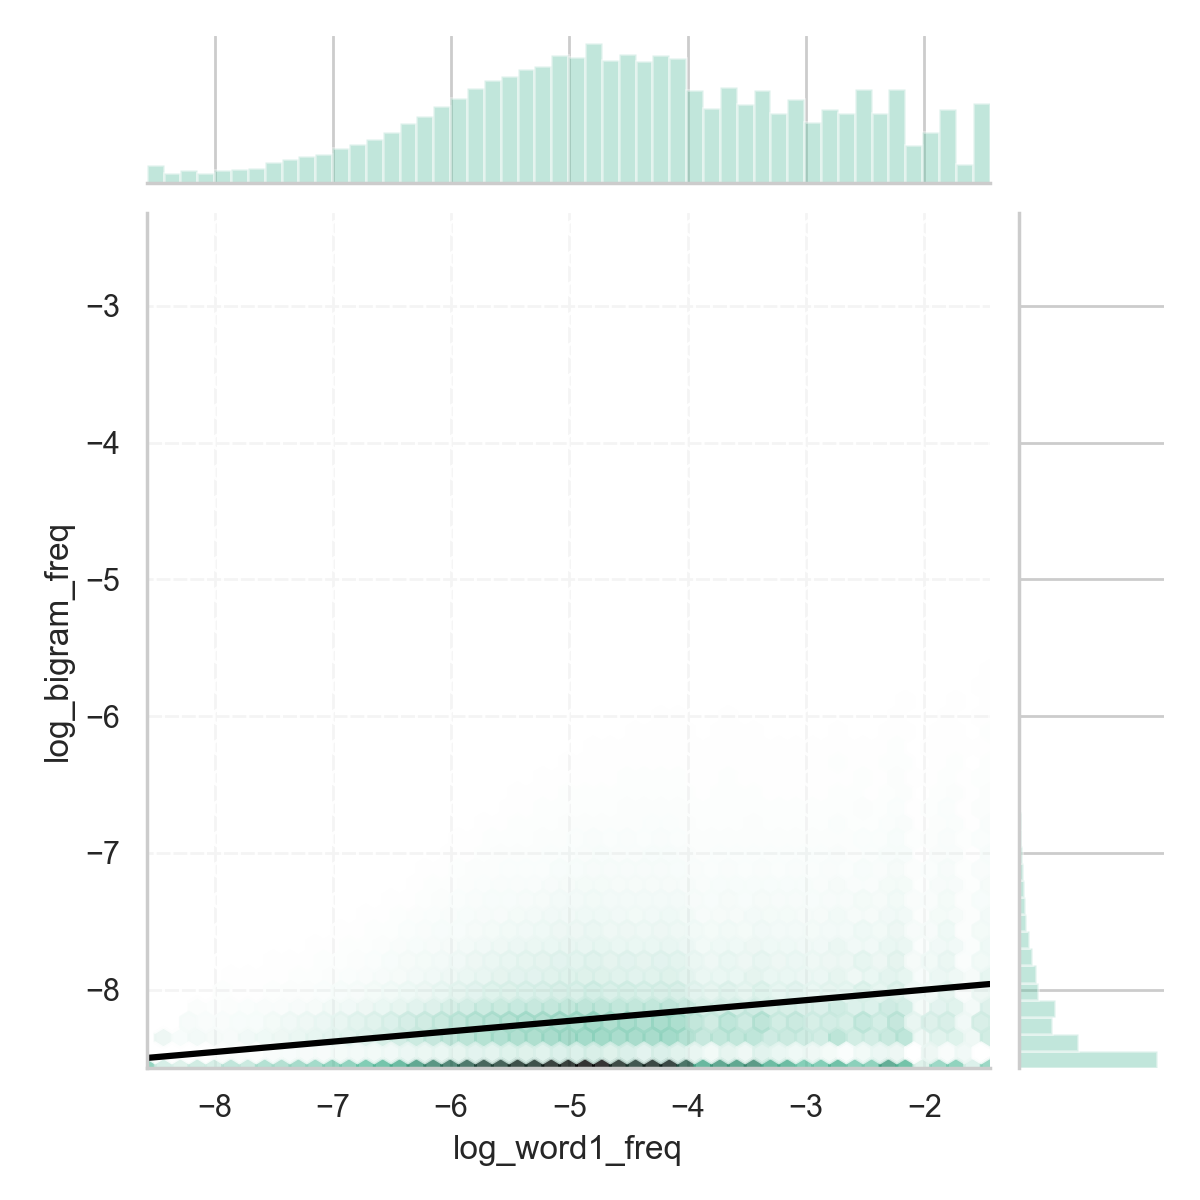

In [73]:
x = df_bi['log_word1_freq']
y = df_bi['log_bigram_freq']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


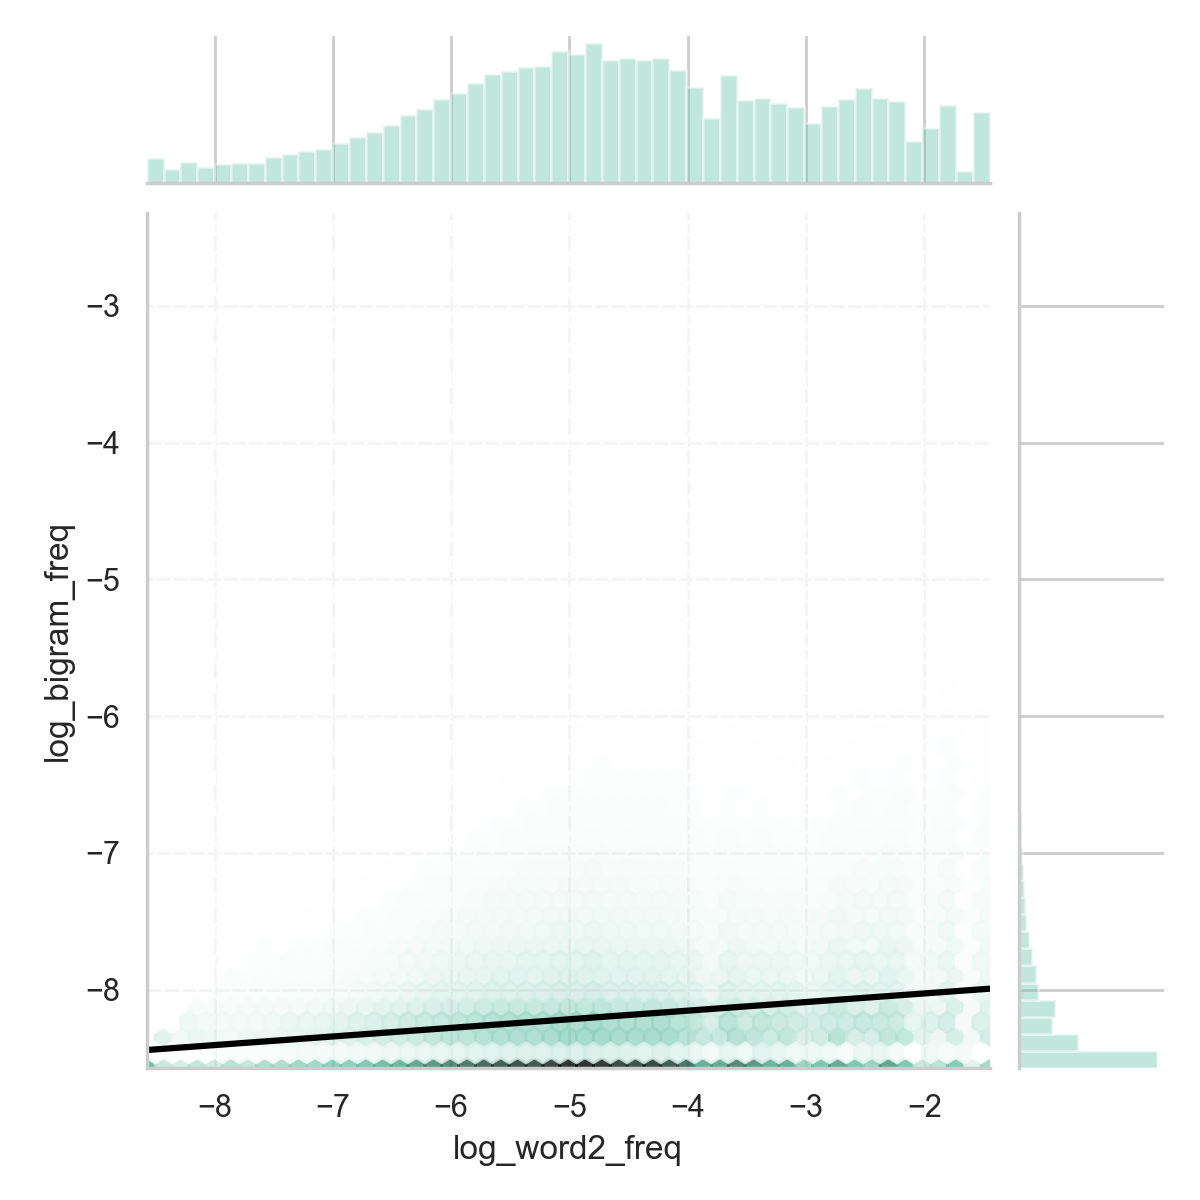

In [74]:
x = df_bi['log_word2_freq']
y = df_bi['log_bigram_freq']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


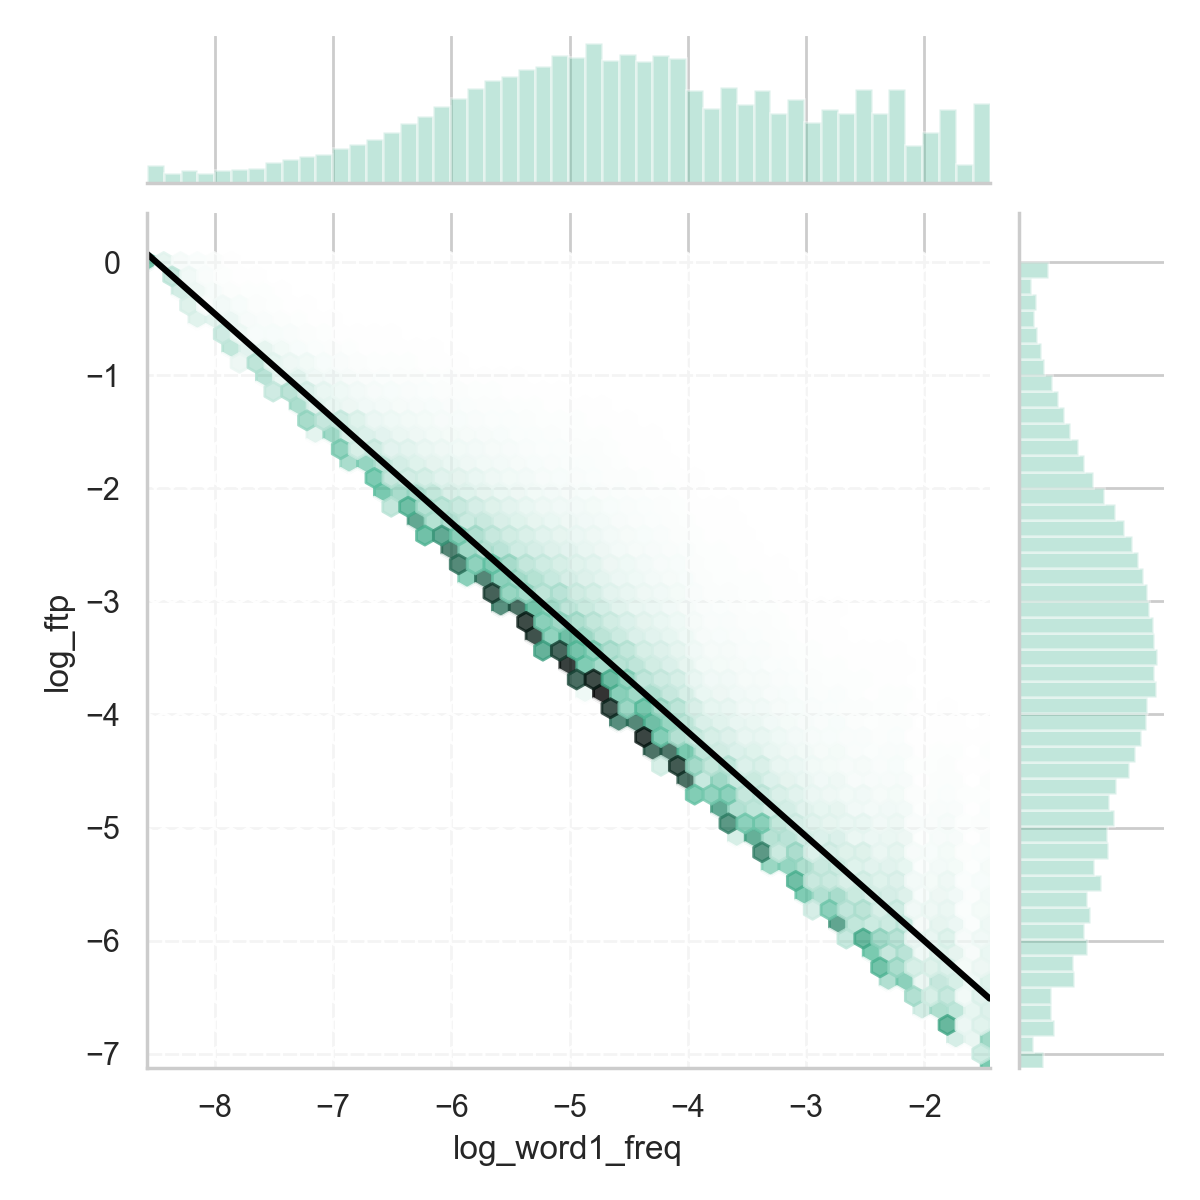

In [75]:
x = df_bi['log_word1_freq']
y = df_bi['log_ftp']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


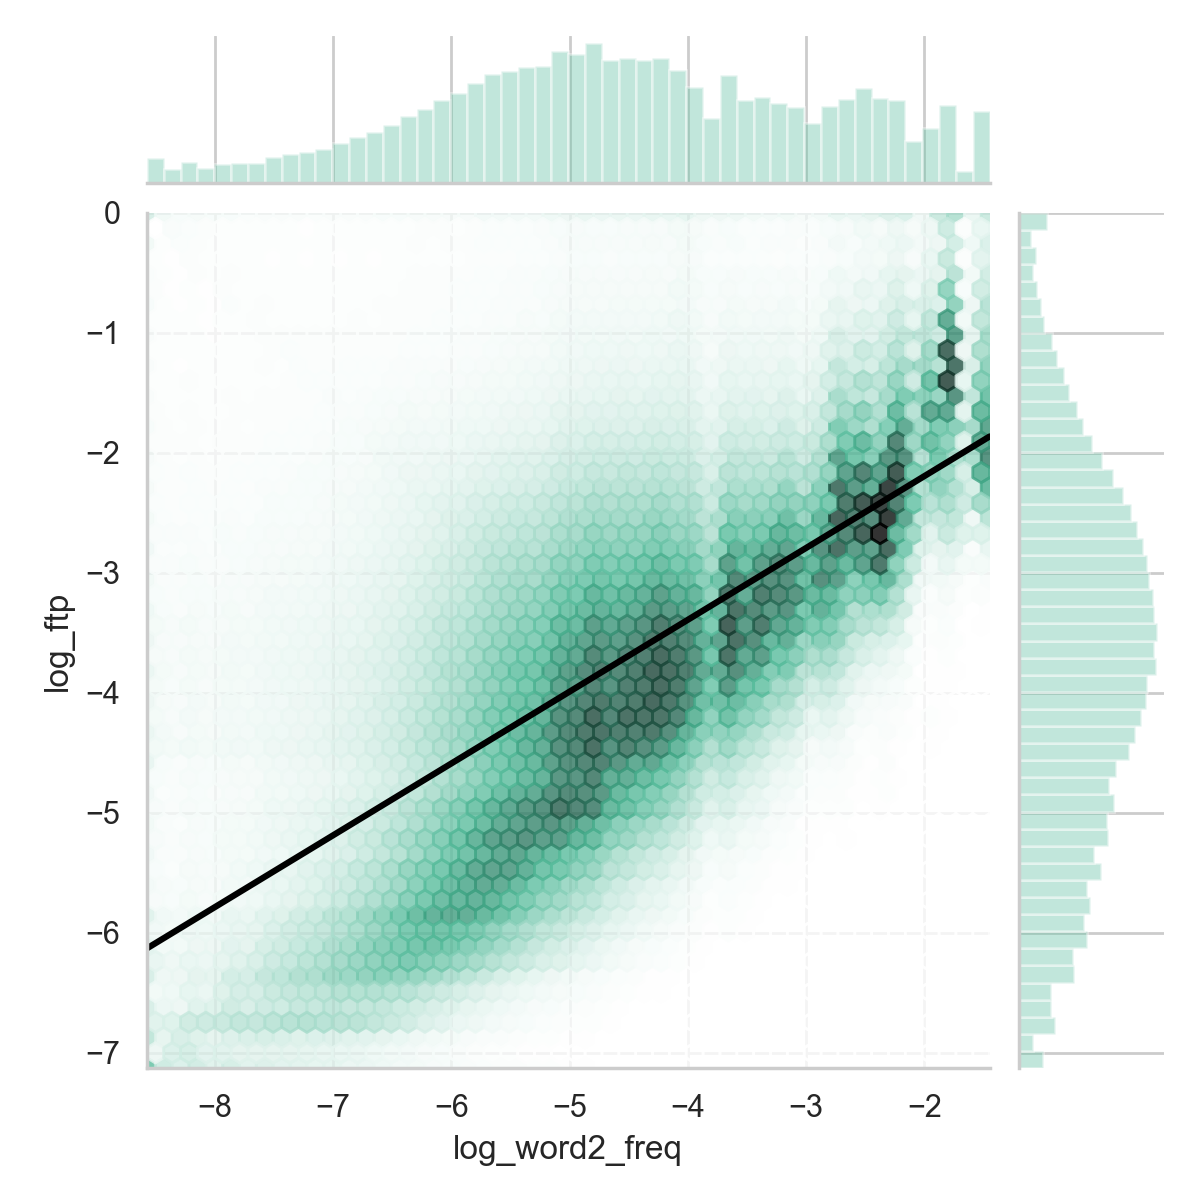

In [76]:
x = df_bi['log_word2_freq']
y = df_bi['log_ftp']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


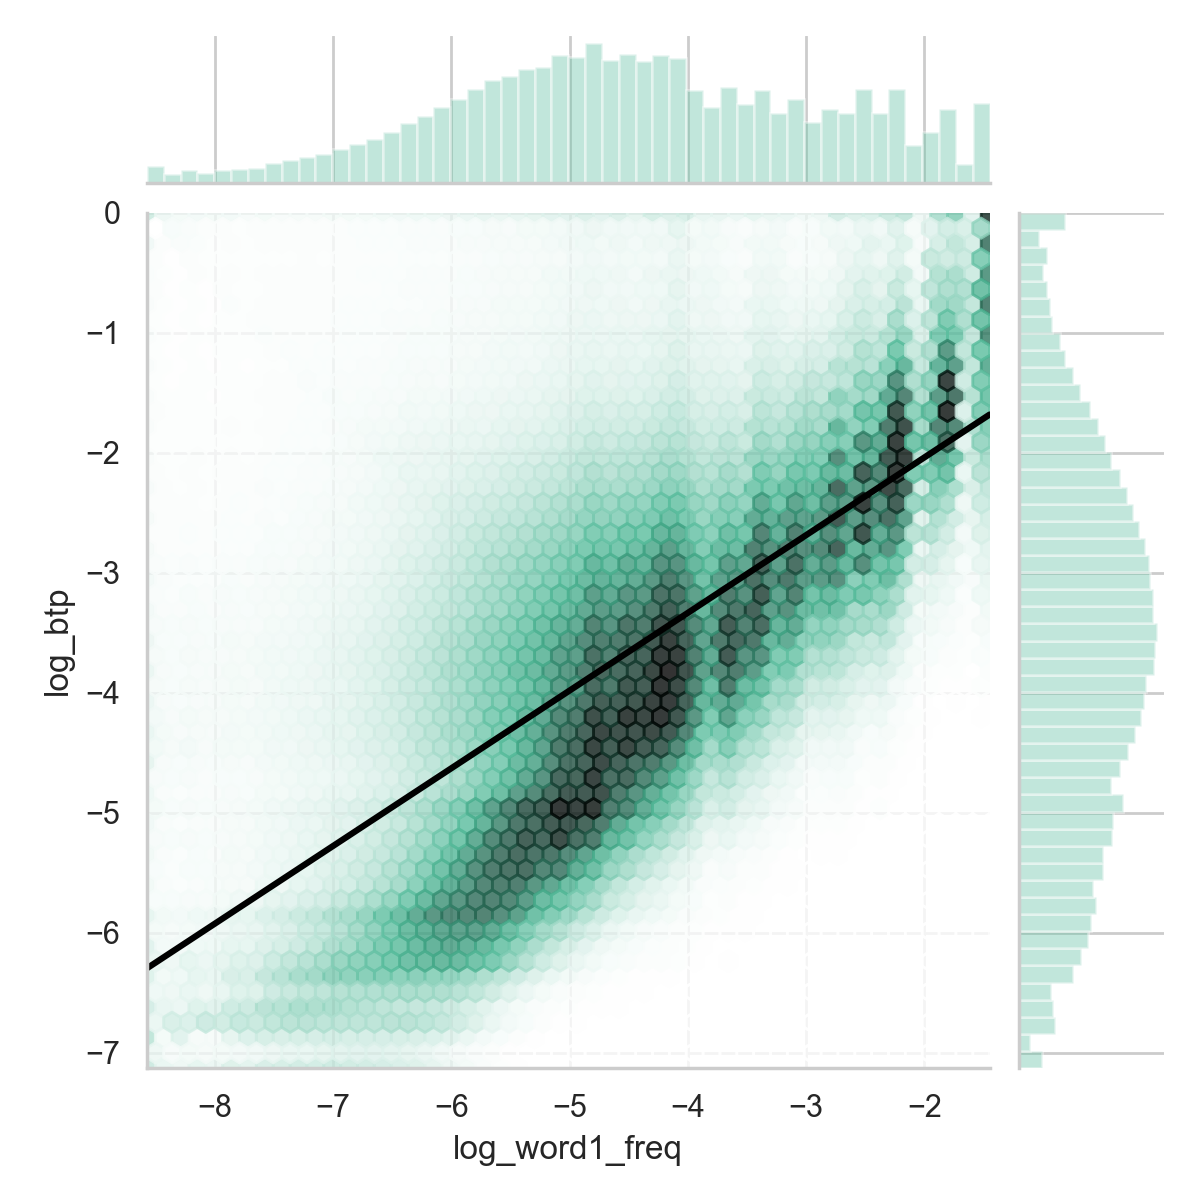

In [77]:
x = df_bi['log_word1_freq']
y = df_bi['log_btp']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


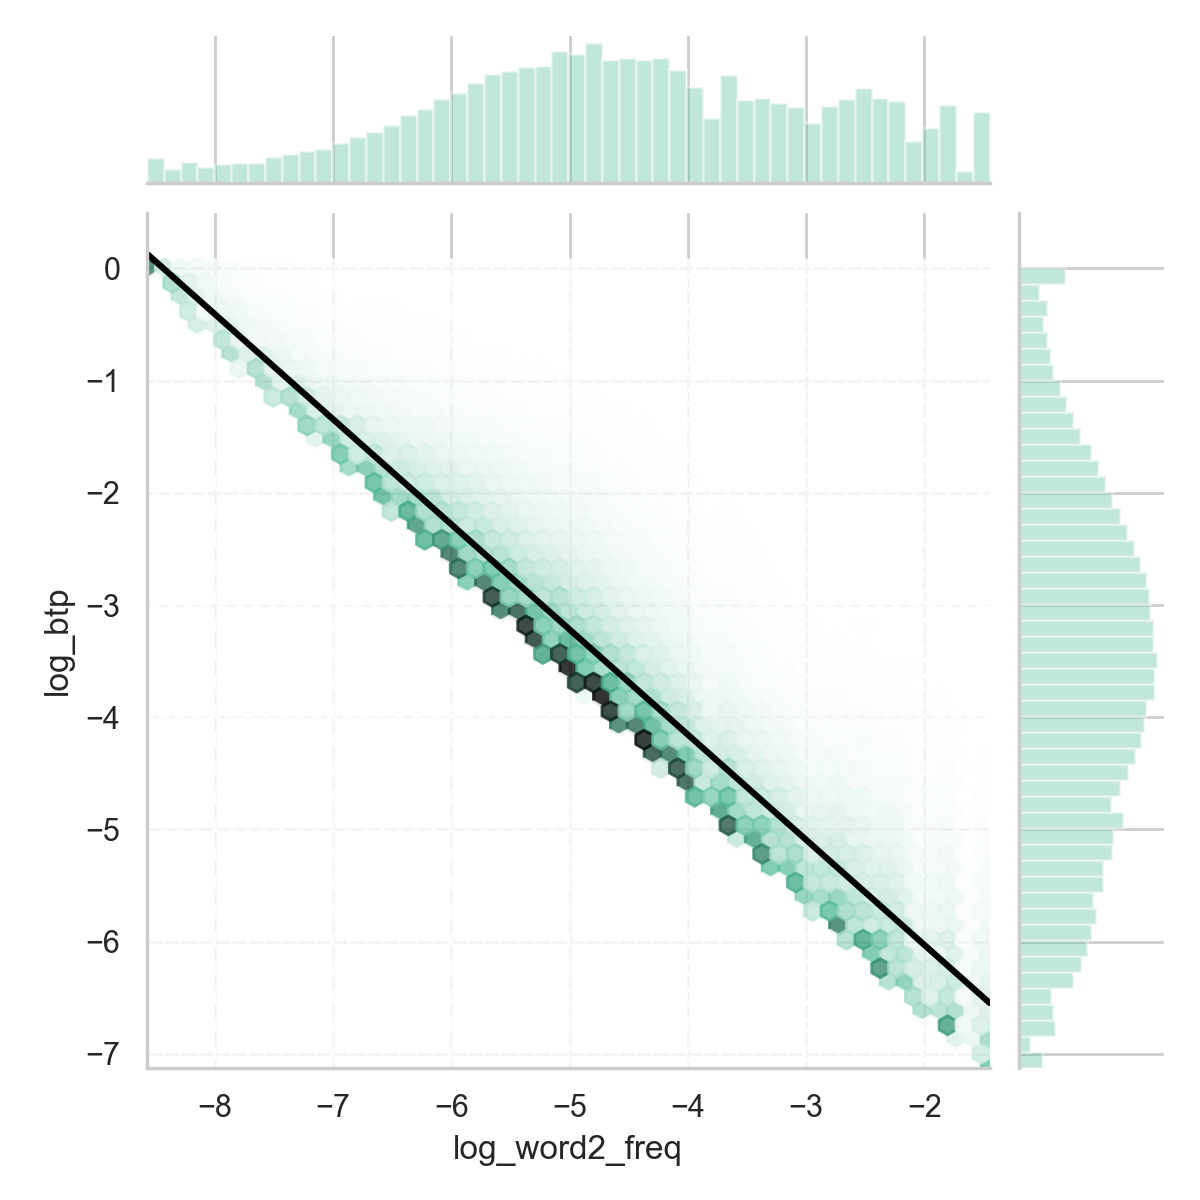

In [78]:
x = df_bi['log_word2_freq']
y = df_bi['log_btp']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


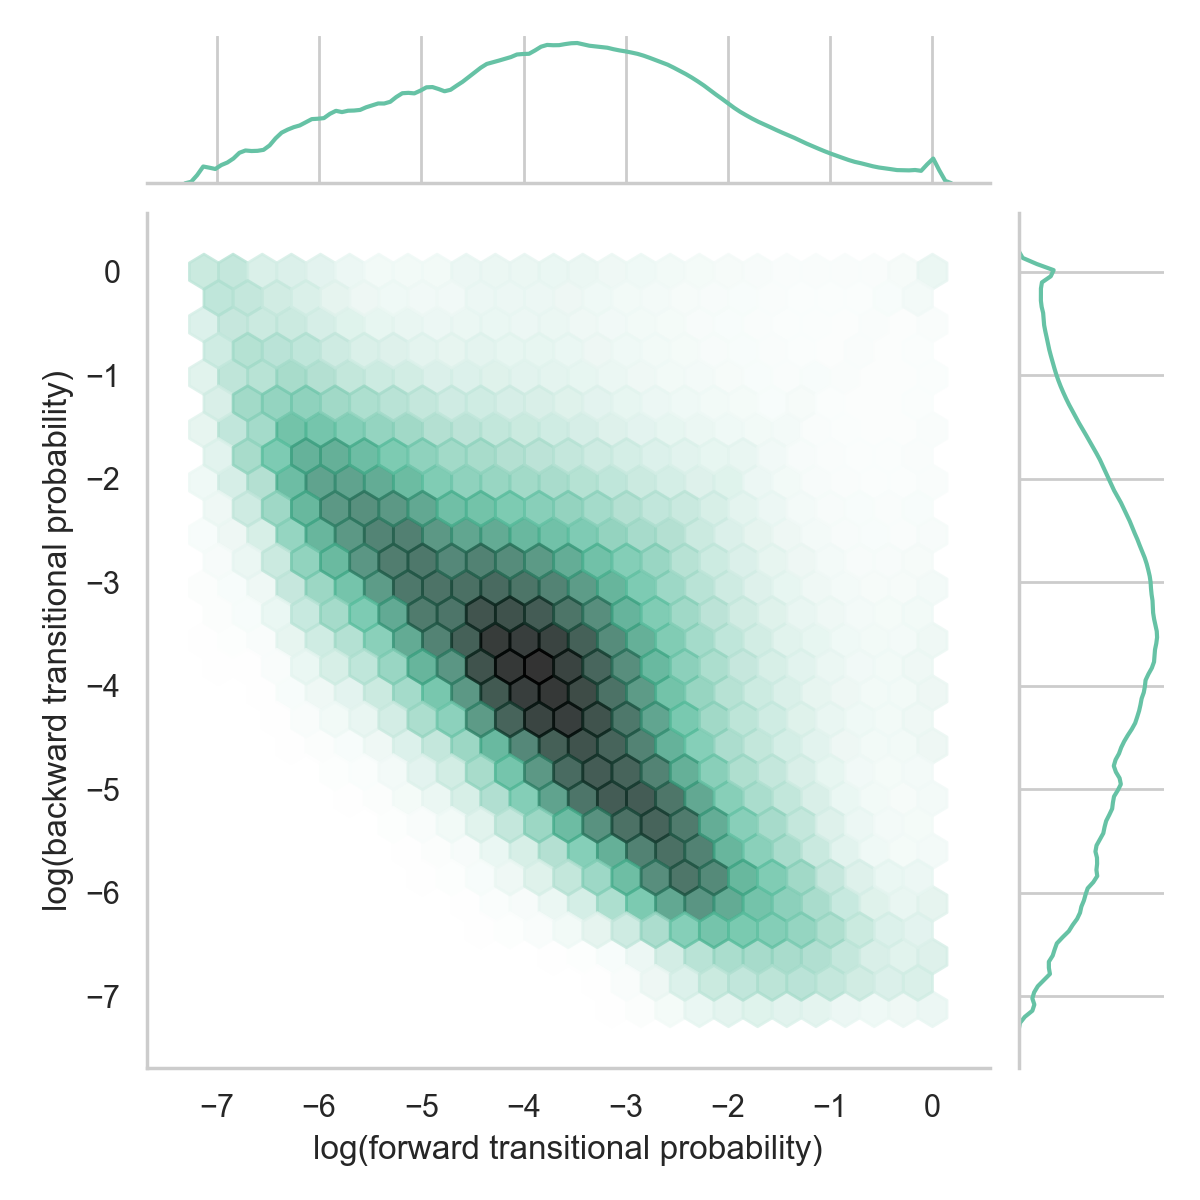

In [55]:
x = df_bi['log_ftp']
y = df_bi['log_btp']
g = sns.jointplot(x, y,
                  kind='hex',
                  alpha=.8,
                  joint_kws={'gridsize': 25},
                  marginal_kws={'hist': False, 'kde': True},
                 )
g.ax_joint.set(xlabel='log(forward transitional probability)', ylabel='log(backward transitional probability)')
g.ax_joint.grid(False)

#sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

plt.savefig('figures/ftp_btp_hexplot.pdf')

<IPython.core.display.Javascript object>


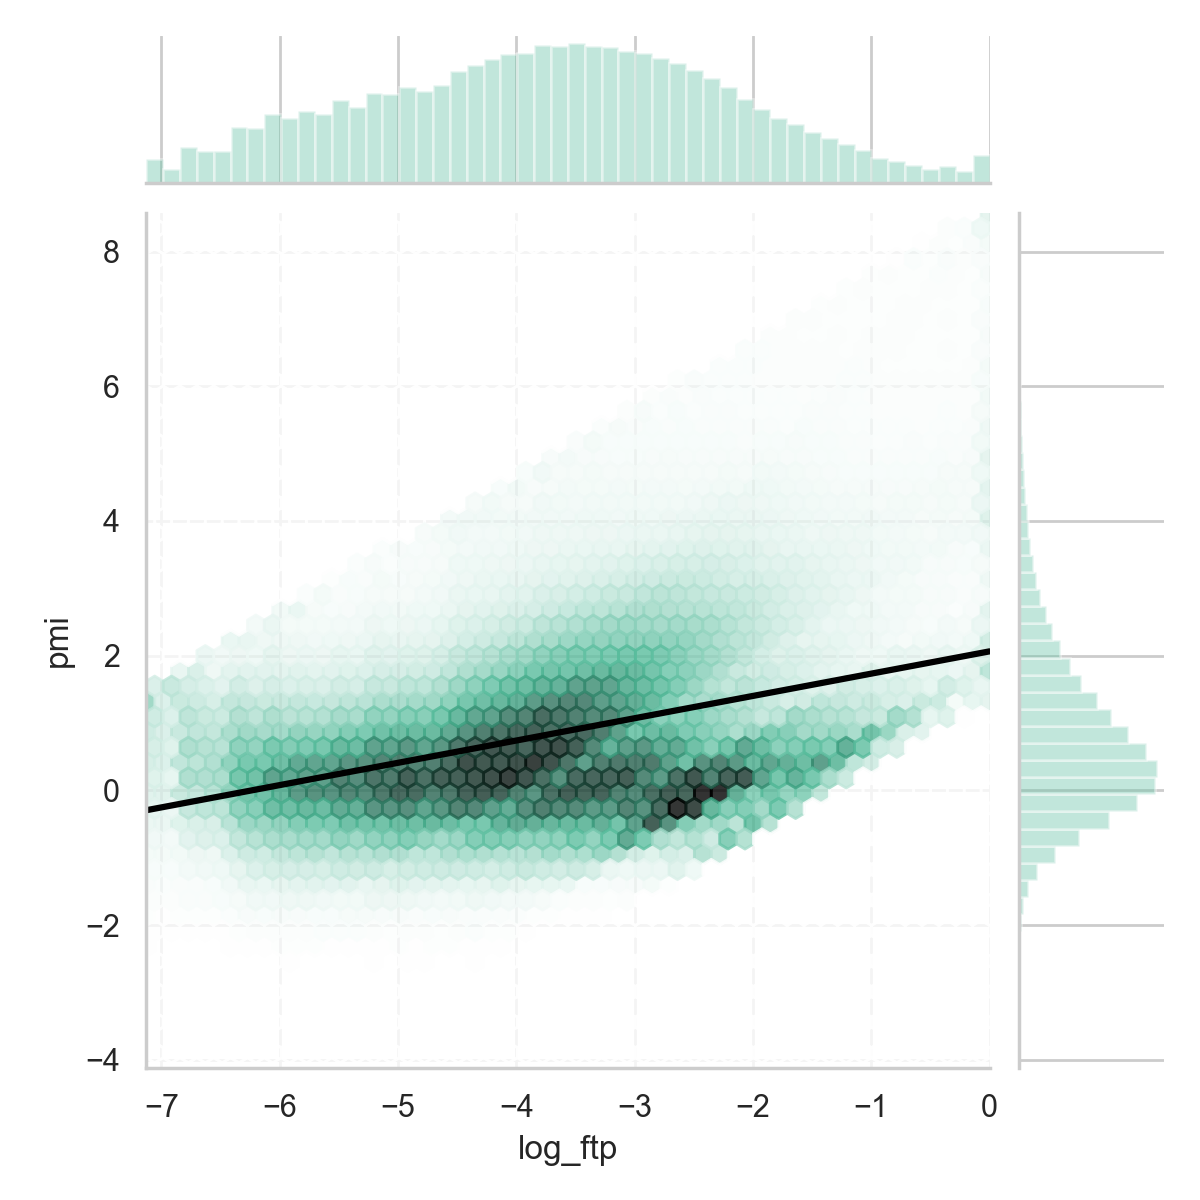

In [80]:
x = df_bi['log_ftp']
y = df_bi['pmi']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


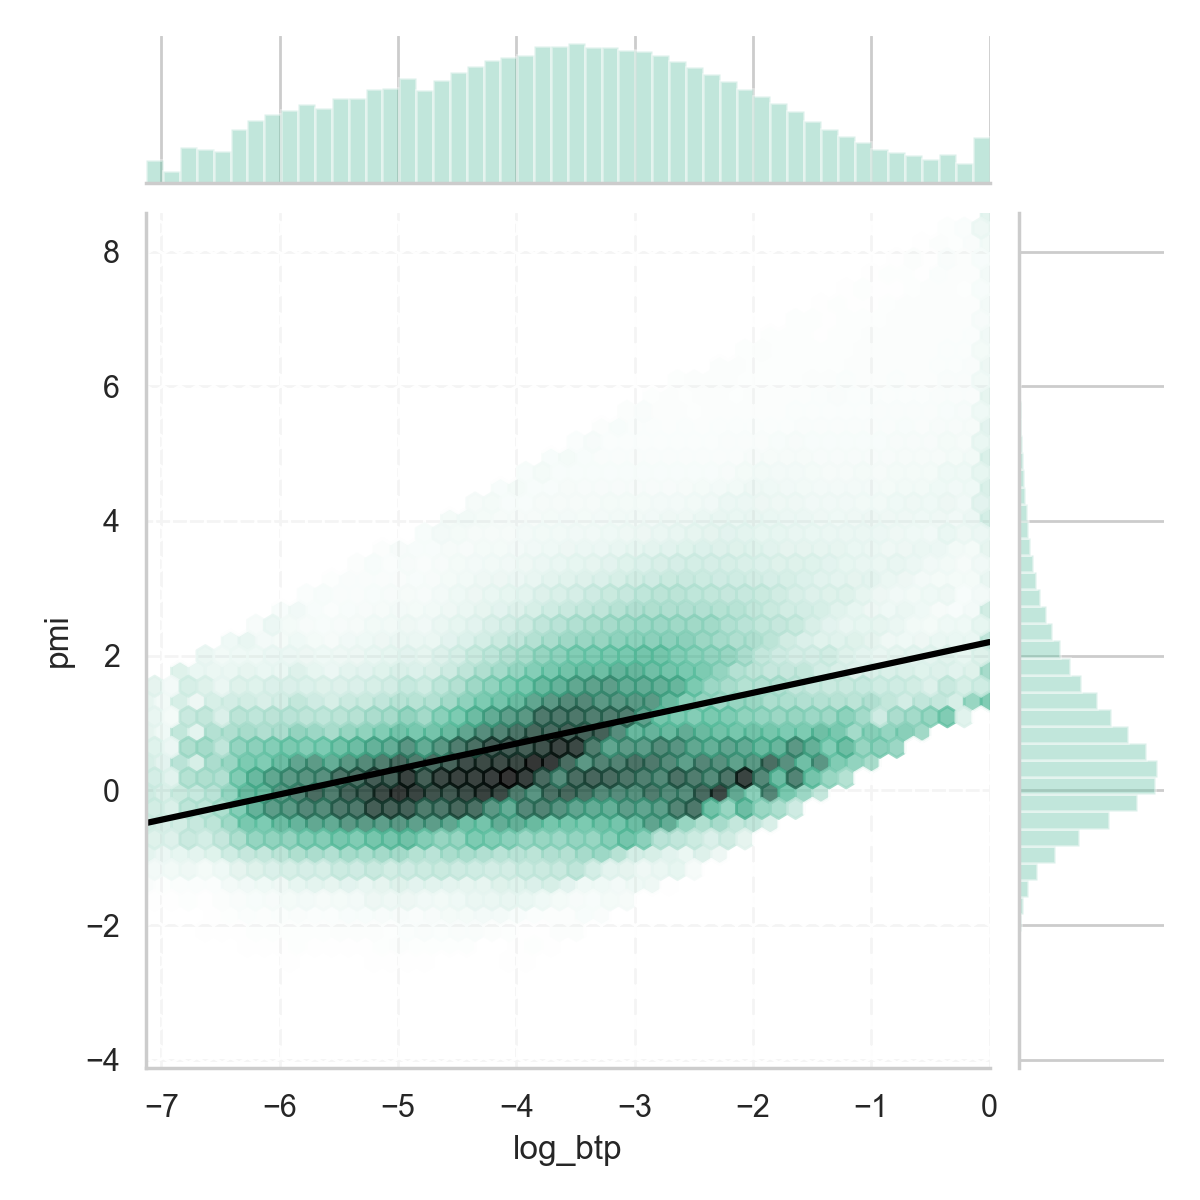

In [81]:
x = df_bi['log_btp']
y = df_bi['pmi']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


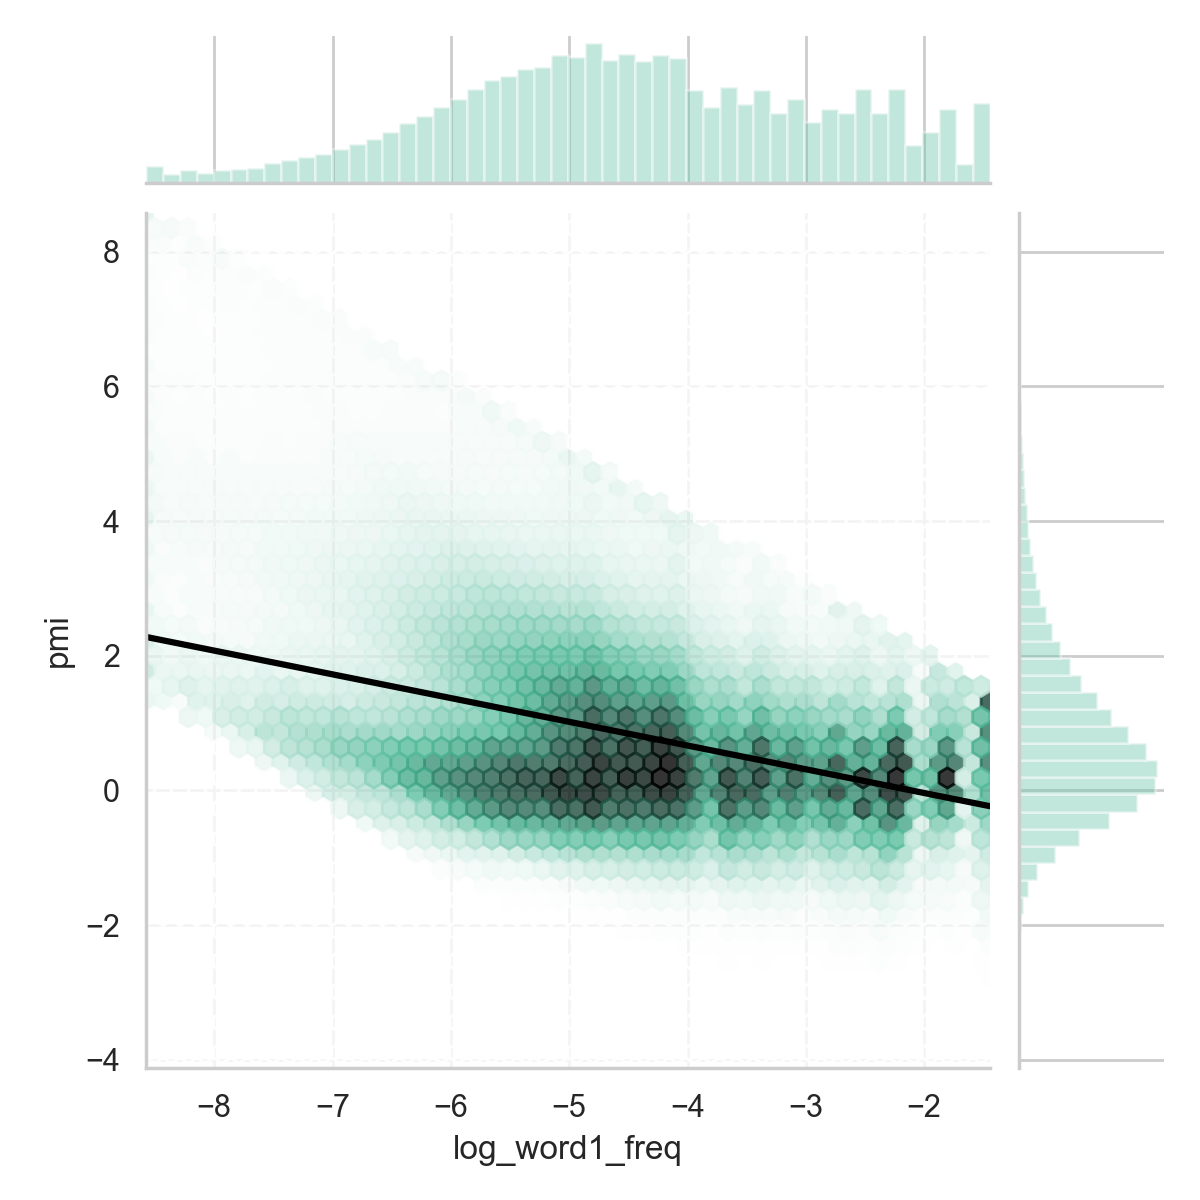

In [82]:
x = df_bi['log_word1_freq']
y = df_bi['pmi']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

<IPython.core.display.Javascript object>


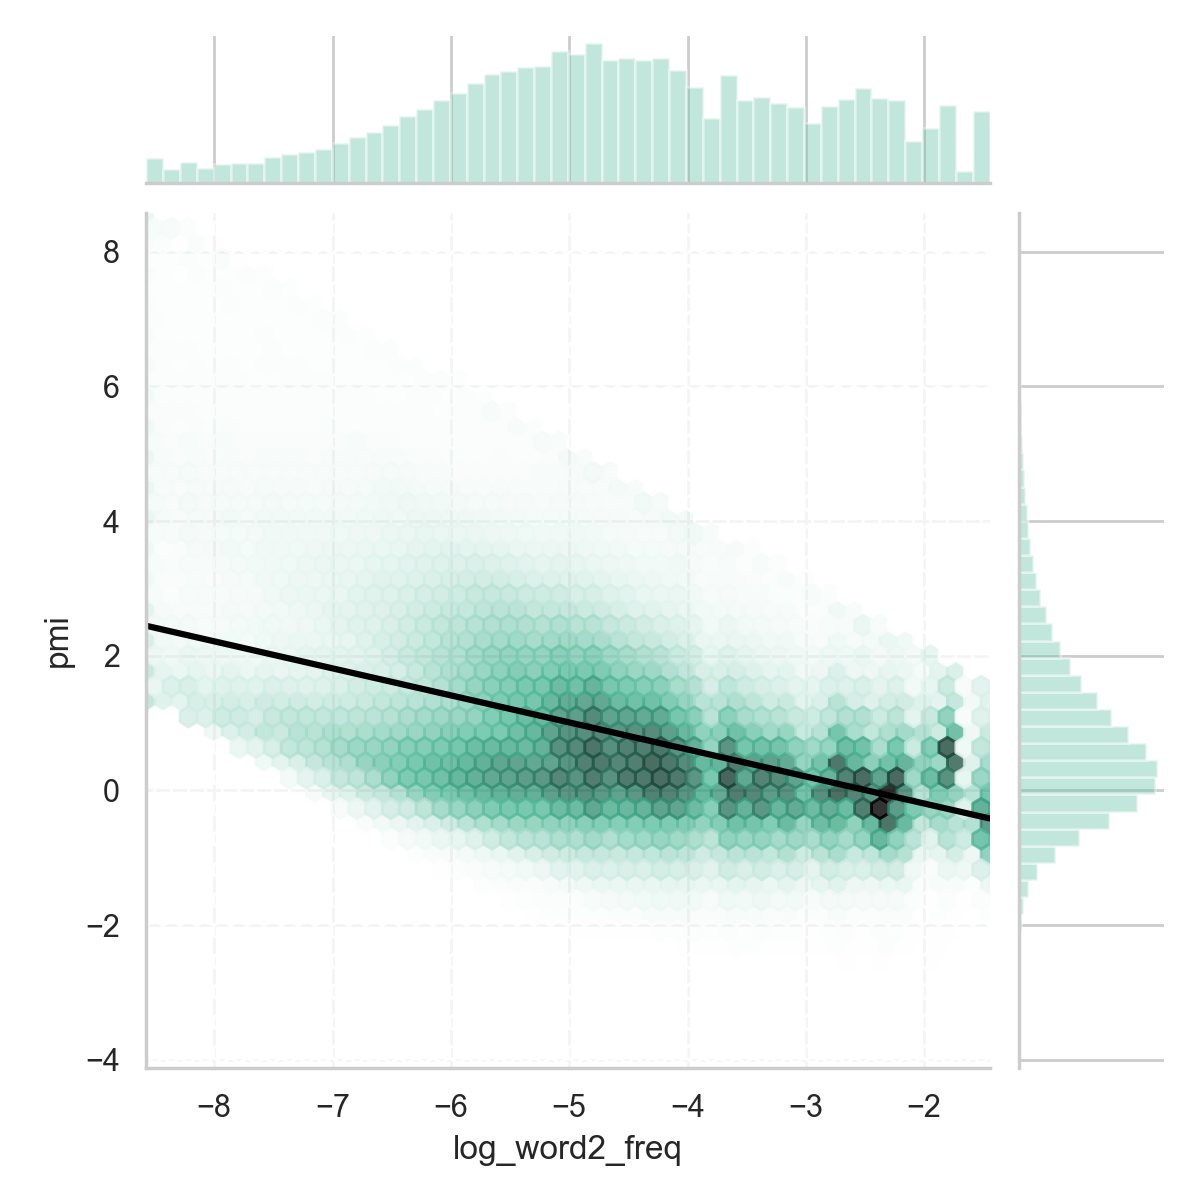

In [83]:
x = df_bi['log_word2_freq']
y = df_bi['pmi']
g = sns.jointplot(x, y, kind='hex', alpha=.8)
sns.regplot(x, y, ax=g.ax_joint, scatter=False, ci=None, color='black');

In [66]:
ev_btp = np.sum(df_bi['log_word1_freq'] * df_bi['log_btp'])
display_md(f'EV for BTP: {ev_btp.round(2)}')
ev_ftp = np.sum(df_bi['log_word2_freq'] * df_bi['log_ftp'])
display_md(f'EV for FTP: {ev_ftp.round(2)}')

EV for BTP: 225091352.81

EV for FTP: 233842682.7

In [58]:
# convert this Jupyter notebook
import subprocess as sp
make_md = 'jupyter nbconvert transitional_probabilities.ipynb --to html --output transitional_probabilities.html'.split(' ')
convert = sp.run(make_md)
if convert.returncode == 0:
    display_md('Jupyter notebook converted successfully.')
else:
    display_md('Error: encountered problem converting Jupyter notebook')

Jupyter notebook converted successfully.